# RTS heatmap regression training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}
</style>

## Import libraries

In [3]:
from pathlib import Path
import geopandas as gpd
from datetime import datetime


In [4]:
import torch
import pytorch_lightning as pl
from torchgeo.datasets import BoundingBox
from rts_utils import get_time_bounds
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary.model_summary import ModelSummary
import fiona
from torchgeo.models import ResNet50_Weights


/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from rts_datamodule_retreat import LandsatDataModule
from rts_model_retreat import SiameseRTS
from rts_path import img_dir, dem_dir, mask_dir, polygon_dir


Running on cryo-A100


## Preparing the data

In [6]:
UTM_CRS = "EPSG:32646"
MINT = datetime.strptime('19840101', "%Y%m%d").timestamp() # parse time_str then convert to POSIX timestamp
MAXT = datetime.strptime('20231231', "%Y%m%d").timestamp()


### Read ROIs for train, val & test

In [7]:
rts_cluster_gdf_path = polygon_dir / 'gt_polygons_round4_4/RTS_cluster_bbox_train_blh_hxm.gpkg'
layer_list = sorted(fiona.listlayers(rts_cluster_gdf_path))
print(layer_list)
bbox_roi_dict_train = {}
for layer in layer_list: 
    year = layer[-4:]
    bbox_cluster_gdf: gpd.GeoDataFrame = gpd.read_file(rts_cluster_gdf_path, layer=layer)
    bbox_cluster_gdf["weight"] = bbox_cluster_gdf["weight"].astype(float)
    bbox_cluster_gdf.loc[bbox_cluster_gdf['cluster_id']==-1, 'weight'] = bbox_cluster_gdf.loc[bbox_cluster_gdf['cluster_id']==-1, 'weight']/10
    bbox_cluster_gdf['roi'] = bbox_cluster_gdf['geometry'].apply(lambda x: BoundingBox(x.bounds[0], x.bounds[2], x.bounds[1], x.bounds[3], MINT, MAXT)) # type: ignore
    bbox_roi_dict_train[year] = bbox_cluster_gdf.loc[:, ['cluster_id', 'roi', 'weight']].to_dict(orient='list')
display(bbox_roi_dict_train.keys())


['RTS_bbox_2016', 'RTS_bbox_2017', 'RTS_bbox_2018', 'RTS_bbox_2019', 'RTS_bbox_2020', 'RTS_bbox_2021', 'RTS_bbox_2022']


dict_keys(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])

In [8]:
# bbox_cluster_gdf

In [9]:
# bbox_cluster_gdf.plot(edgecolor='red', facecolor='None')

In [10]:
rts_cluster_gdf_path = polygon_dir / 'gt_polygons_round4_4/RTS_cluster_bbox_validation_blh_hxm.gpkg'
layer_list = sorted(fiona.listlayers(rts_cluster_gdf_path))
print(layer_list)
bbox_roi_dict_valid = {}
for layer in layer_list: 
    year = layer[-4:]
    bbox_cluster_gdf: gpd.GeoDataFrame = gpd.read_file(rts_cluster_gdf_path, layer=layer)
    bbox_cluster_gdf["weight"] = bbox_cluster_gdf["weight"].astype(float)
    bbox_cluster_gdf.loc[bbox_cluster_gdf['cluster_id']==-1, 'weight'] = bbox_cluster_gdf.loc[bbox_cluster_gdf['cluster_id']==-1, 'weight']/10
    bbox_cluster_gdf['roi'] = bbox_cluster_gdf['geometry'].apply(lambda x: BoundingBox(x.bounds[0], x.bounds[2], x.bounds[1], x.bounds[3], MINT, MAXT)) # type: ignore
    # bbox_cluster_gdf.plot(aspect=1, edgecolor='blue', facecolor='None')
    bbox_roi_dict_valid[year] = bbox_cluster_gdf.loc[:, ['cluster_id', 'roi', 'weight']].to_dict(orient='list')
display(bbox_roi_dict_valid.keys())


['RTS_bbox_1984', 'RTS_bbox_2005', 'RTS_bbox_2009', 'RTS_bbox_2011', 'RTS_bbox_2012']


dict_keys(['1984', '2005', '2009', '2011', '2012'])

In [11]:
print("keys in bbox_roi_dict_valid:", bbox_roi_dict_valid.keys())
print("keys in bbox_roi_dict_train:", bbox_roi_dict_train.keys())

keys in bbox_roi_dict_valid: dict_keys(['1984', '2005', '2009', '2011', '2012'])
keys in bbox_roi_dict_train: dict_keys(['2016', '2017', '2018', '2019', '2020', '2021', '2022'])


In [12]:
def build_year_dict_from_pairs(pairs_tm1_t, roi_dict_train, roi_dict_valid, default_weight=1):
    """
    pairs_tm1_t: List[(tm1, t)]
    roi_dict_train / roi_dict_valid: 两个 ROI 字典
    返回 year_dict = {'year':[t...], 'weight':[...], 'roi':[tm1年的ROI条目...]}
    """
    years, weights, rois = [], [], []
    for tm1, t in pairs_tm1_t:
        tm1_str = str(int(tm1))
        if tm1_str in roi_dict_train:
            roi = roi_dict_train[tm1_str]
        elif tm1_str in roi_dict_valid:
            roi = roi_dict_valid[tm1_str]
        else:
            print(f"[skip] 两个字典都没有年份 {tm1}")
            continue
        years.append(int(t))
        weights.append(default_weight)
        rois.append(roi)
    return {"year": years, "weight": weights, "roi": rois}

# 你的希望配对（tm1, t）
train_pairs = [
    # (2011, 2012),  # 2012 不存在，移除
    # (2014, 2015),
    # (2015, 2016),
    (2016, 2017),
    # (2017, 2018),
    # (2018, 2019),
    (2020, 2021),
    (2021, 2022),
]
val_pairs = [(2019, 2020)]
test_pairs = [(2019, 2020)]

# 构造 year_dict
year_dict_train = build_year_dict_from_pairs(train_pairs, bbox_roi_dict_train, bbox_roi_dict_valid)
year_dict_val = build_year_dict_from_pairs(val_pairs, bbox_roi_dict_train, bbox_roi_dict_valid)
year_dict_test = build_year_dict_from_pairs(test_pairs, bbox_roi_dict_train, bbox_roi_dict_valid)

print("train years:", year_dict_train["year"])
print("val years:", year_dict_val["year"])
print("test years:", year_dict_test["year"])

train years: [2017, 2021, 2022]
val years: [2020]
test years: [2020]


In [13]:
# from datetime import datetime
# from torchgeo.datasets import BoundingBox as TGBB
# from rts_dataset_retreat import Landsat8SR, Landsat57SR, RtsMask

# BAND_NUM = 4

# def ybbox(b, y):  # 严格年窗
#     return TGBB(b.minx, b.maxx, b.miny, b.maxy, datetime(y,1,1).timestamp(), datetime(y+1,1,1).timestamp())

# def has_hits(ds, qb):  # 覆盖检查
#     return len(list(ds.index.intersection(tuple(qb), objects=True))) > 0

# def pick_ds(y, ds_l89, ds_l57):  # 选择传感器
#     return ds_l89 if y>2012 else ds_l57

# def filter_year_dict_strict_t_minus_1(ds_l89, ds_l57, mask_ds, year_dict):
#     years, weights, rois = year_dict["year"], year_dict["weight"], year_dict["roi"]
#     out_y, out_w, out_rois = [], [], []
#     for y, w, roi_entry in zip(years, weights, rois):
#         y = int(y)
#         ds_t   = pick_ds(y, ds_l89, ds_l57)
#         ds_tm1 = pick_ds(y-1, ds_l89, ds_l57)
#         if ds_t is None or ds_tm1 is None: continue
#         roi_list = roi_entry["roi"]
#         valid_idx = []
#         for i, bx in enumerate(roi_list):
#             if has_hits(ds_t, ybbox(bx,y)) and has_hits(ds_tm1, ybbox(bx,y-1)) and has_hits(mask_ds, ybbox(bx,y)):
#                 valid_idx.append(i)
#         if valid_idx:
#             out_y.append(y); out_w.append(w)
#             out_rois.append({k: (roi_entry[k] if k!="roi" else [roi_list[j] for j in valid_idx]) for k in roi_entry.keys()})
#     return {"year": out_y, "weight": out_w, "roi": out_rois}

# # 审计数据集（只用于过滤，不参与训练）
# ds_l89_audit = Landsat8SR(root=str(img_dir), crs=UTM_CRS, bands=["SR_B2","SR_B3","SR_B4","SR_B5"] if BAND_NUM==4 else None, res=30, cache=False)
# ds_l57_audit = Landsat57SR(root=str(img_dir), crs=UTM_CRS, bands=["SR_B1","SR_B2","SR_B3","SR_B4"] if BAND_NUM==4 else None, res=30, cache=False)
# mask_ds_audit= RtsMask(root=str(mask_dir), crs=UTM_CRS, bands=["heatmap","segment","retreat"], res=30, cache=False)

# # 过滤（至少对 train 过滤；val/test可选）
# year_dict_train = filter_year_dict_strict_t_minus_1(ds_l89_audit, ds_l57_audit, mask_ds_audit, year_dict_train)
# year_dict_val   = filter_year_dict_strict_t_minus_1(ds_l89_audit, ds_l57_audit, mask_ds_audit, year_dict_val)
# year_dict_test  = filter_year_dict_strict_t_minus_1(ds_l89_audit, ds_l57_audit, mask_ds_audit, year_dict_test)
# print("train years after filter:", year_dict_train["year"])
# print("val years after filter:", year_dict_val["year"])
# print("test years after filter:", year_dict_test["year"])

### Initialize the datamodule

In [14]:
# 在 build_year_dict_from_pairs 之后、创建 LandsatDataModule 之前添加此 cell

from datetime import datetime
from torchgeo.datasets import BoundingBox as TGBB
from rts_dataset_retreat import Landsat8SR, Landsat57SR, RtsMask

def ybbox(b, y):
    """创建严格年份边界的 bbox"""
    return TGBB(b.minx, b.maxx, b.miny, b.maxy, 
                datetime(y, 1, 1).timestamp(), 
                datetime(y, 12, 31, 23, 59, 59).timestamp())

def has_year_coverage_strict(ds, bbox, year):
    """严格检查：该空间范围内是否有指定年份的文件"""
    qb = ybbox(bbox, year)
    hits = list(ds.index.intersection(tuple(qb), objects=True))
    for h in hits:
        dir_year = ds._extract_dir_year(h.object)
        if dir_year == year:
            return True
    return False

def pick_ds(y, ds_l89, ds_l57):
    return ds_l89 if y > 2012 else ds_l57

def filter_year_dict_strict(year_dict, ds_l89, ds_l57, mask_ds):
    """过滤 year_dict，只保留 t 年和 t-1 年都有完整覆盖的 ROI"""
    years = year_dict["year"]
    weights = year_dict["weight"]
    rois = year_dict["roi"]
    
    out_years, out_weights, out_rois = [], [], []
    
    for t, w, roi_entry in zip(years, weights, rois):
        t = int(t)
        tm1 = t - 1
        ds_t = pick_ds(t, ds_l89, ds_l57)
        ds_tm1 = pick_ds(tm1, ds_l89, ds_l57)
        
        roi_list = roi_entry["roi"]
        cluster_ids = roi_entry.get("cluster_id", list(range(len(roi_list))))
        weights_list = roi_entry.get("weight", [1.0] * len(roi_list))
        
        valid_indices = []
        for i, bx in enumerate(roi_list):
            ok_t = has_year_coverage_strict(ds_t, bx, t)
            ok_tm1 = has_year_coverage_strict(ds_tm1, bx, tm1)
            ok_mask = has_year_coverage_strict(mask_ds, bx, t)
            
            if ok_t and ok_tm1 and ok_mask:
                valid_indices.append(i)
        
        if valid_indices:
            out_years.append(t)
            out_weights.append(w)
            out_rois.append({
                "cluster_id": [cluster_ids[j] for j in valid_indices],
                "roi": [roi_list[j] for j in valid_indices],
                "weight": [weights_list[j] for j in valid_indices],
            })
            print(f"[{tm1}->{t}] 保留 {len(valid_indices)}/{len(roi_list)} 个 ROI")
        else:
            print(f"[{tm1}->{t}] ⚠️ 没有有效 ROI，跳过该年份对")
    
    return {"year": out_years, "weight": out_weights, "roi": out_rois}

# ============ 创建审计数据集 ============
print("创建审计数据集...")
ds_l89_audit = Landsat8SR(root=str(img_dir), crs=UTM_CRS, 
                          bands=["SR_B2","SR_B3","SR_B4","SR_B5"], res=30, cache=False)
ds_l57_audit = Landsat57SR(root=str(img_dir), crs=UTM_CRS, 
                           bands=["SR_B1","SR_B2","SR_B3","SR_B4"], res=30, cache=False)
mask_ds_audit = RtsMask(root=str(mask_dir), crs=UTM_CRS, 
                        bands=["heatmap","segment","retreat"], res=30, cache=False)

# ============ 过滤 year_dict ============
print("\n过滤 train ROIs...")
year_dict_train = filter_year_dict_strict(year_dict_train, ds_l89_audit, ds_l57_audit, mask_ds_audit)

print("\n过滤 val ROIs...")
year_dict_val = filter_year_dict_strict(year_dict_val, ds_l89_audit, ds_l57_audit, mask_ds_audit)

print("\n过滤 test ROIs...")
year_dict_test = filter_year_dict_strict(year_dict_test, ds_l89_audit, ds_l57_audit, mask_ds_audit)

print("\n" + "=" * 60)
print("过滤后的年份配置:")
print(f"  train years: {year_dict_train['year']}")
print(f"  val years: {year_dict_val['year']}")
print(f"  test years: {year_dict_test['year']}")
for t, roi in zip(year_dict_train['year'], year_dict_train['roi']):
    print(f"    {t-1}->{t}: {len(roi['roi'])} ROIs")

创建审计数据集...


[Landsat8SR] Reindexed 70 files by directory year
[Landsat57SR] Reindexed 59 files by directory year
[RtsMask] Reindexed 38 files by directory year

过滤 train ROIs...
[2016->2017] 保留 37/37 个 ROI
[2020->2021] 保留 41/41 个 ROI
[2021->2022] 保留 41/41 个 ROI

过滤 val ROIs...
[2019->2020] 保留 39/39 个 ROI

过滤 test ROIs...
[2019->2020] 保留 39/39 个 ROI

过滤后的年份配置:
  train years: [2017, 2021, 2022]
  val years: [2020]
  test years: [2020]
    2016->2017: 37 ROIs
    2020->2021: 41 ROIs
    2021->2022: 41 ROIs


In [15]:

BAND_NUM = 4
USE_DEM = True

landsat_dm = LandsatDataModule(
    img_dir=str(img_dir),
    mask_dir=str(mask_dir),
    dem_dir=str(dem_dir),
    train_length=32*100,
    val_length=500,
    test_length=1000,
    year_dict_train=year_dict_train,
    year_dict_val=year_dict_val,
    year_dict_test=year_dict_val,
    band_num=BAND_NUM,
    use_dem=USE_DEM,
    batch_size=32, # 16
    patch_size=256,
    crs=UTM_CRS,
    res=30,
    use_l7=True,
    retreat_dir="/home/ww/ww_cryostore/BLH_heatmap/30m",
)

[Landsat8SR] Reindexed 70 files by directory year
[Landsat57SR] Reindexed 59 files by directory year
[RtsMask] Reindexed 38 files by directory year


In [16]:
batch = next(iter(landsat_dm.train_dataloader()))

print("year_t:", batch["year_t"][:32])
print("year_tm1:", batch["year_tm1"][:32])

year_t: [2021, 2021, 2017, 2022, 2017, 2017, 2017, 2022, 2021, 2017, 2021, 2021, 2017, 2021, 2017, 2017, 2022, 2022, 2022, 2021, 2022, 2021, 2017, 2021, 2017, 2017, 2017, 2022, 2021, 2022, 2021, 2021]
year_tm1: [2020, 2020, 2016, 2021, 2016, 2016, 2016, 2021, 2020, 2016, 2020, 2020, 2016, 2020, 2016, 2016, 2021, 2021, 2021, 2020, 2021, 2020, 2016, 2020, 2016, 2016, 2016, 2021, 2020, 2021, 2020, 2020]


In [17]:
# ========== 验证年份匹配 ==========
batch = next(iter(landsat_dm.train_dataloader()))

print("=" * 70)
print("验证年份匹配（直接检查路径是否包含年份）")
print("=" * 70)

all_ok = True
for i in range(min(10, batch["image_t"].shape[0])):
    yt = int(batch["year_t"][i])
    ytm1 = int(batch["year_tm1"][i])
    pt = batch["path_t"][i]
    ptm1 = batch["path_tm1"][i]
    
    t_ok = str(yt) in pt
    tm1_ok = str(ytm1) in ptm1
    
    status_t = "✓" if t_ok else "✗"
    status_tm1 = "✓" if tm1_ok else "✗"
    
    if not (t_ok and tm1_ok):
        all_ok = False
    
    print(f"[{i}] year_t={yt} in path? {status_t} | year_tm1={ytm1} in path? {status_tm1}")
    if not t_ok or not tm1_ok:
        print(f"path_t: {pt}")
        print(f"path_tm1: {ptm1}")

print("=" * 70)
print("✅ 全部匹配！" if all_ok else "⚠️ 存在不匹配，请检查")

验证年份匹配（直接检查路径是否包含年份）
[0] year_t=2022 in path? ✓ | year_tm1=2021 in path? ✓
[1] year_t=2021 in path? ✓ | year_tm1=2020 in path? ✓
[2] year_t=2017 in path? ✓ | year_tm1=2016 in path? ✓
[3] year_t=2022 in path? ✓ | year_tm1=2021 in path? ✓
[4] year_t=2017 in path? ✓ | year_tm1=2016 in path? ✓
[5] year_t=2021 in path? ✓ | year_tm1=2020 in path? ✓
[6] year_t=2022 in path? ✓ | year_tm1=2021 in path? ✓
[7] year_t=2022 in path? ✓ | year_tm1=2021 in path? ✓
[8] year_t=2021 in path? ✓ | year_tm1=2020 in path? ✓
[9] year_t=2017 in path? ✓ | year_tm1=2016 in path? ✓
✅ 全部匹配！


In [18]:
# check loader path

batch = next(iter(landsat_dm.train_dataloader()))

for i in range(batch["image_t"].shape[0]):
    yt = int(batch["year_t"][i])
    ytm1 = int(batch["year_tm1"][i])
    pt = batch["path_t"][i]
    ptm1 = batch["path_tm1"][i]
    print(f"[sample {i}] year_t={yt}, year_tm1={ytm1}")
    print(f" path_t: {pt}")
    print(f" path_tm1: {ptm1}")
    

[sample 0] year_t=2017, year_tm1=2016
 path_t: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2017/LANDSAT_LC08_C02_T1_L2_LC08_137036_20170728_Cloud_09_clip.tif
 path_tm1: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2016/LANDSAT_LE07_C02_T1_L2_LE07_137138_20160802_20160818_geometric_median_beiluhe_hohxil_utm.tif
[sample 1] year_t=2021, year_tm1=2020
 path_t: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2021/LANDSAT_LE07_C02_T1_L2_LE07_137138_20210706_20211010_geometric_median_beiluhe_hohxil_utm.tif
 path_tm1: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2020/LANDSAT_LE07_C02_T1_L2_LE07_137138_20200820_20201007_geometric_median_beiluhe_hohxil_utm.tif
[sample 2] year_t=2022, year_tm1=2021
 path_t: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2022/LANDSAT_LE07_C02_T1_L2_LE07_137138_20220726_20220817_mosaic_beiluhe_hohxil_utm.tif
 path_tm1: /DATA/DATA1/joey/LANDSAT_LC08_MIX/2021/LANDSAT_LE07_C02_T1_L2_LE07_137138_20210706_20211010_geometric_median_beiluhe_hohxil_utm.tif
[sample 3] year_t=2021, year_tm1=2020
 path_t: /DATA/DATA1/joey/LANDSAT_LC0

In [19]:
from collections import Counter
import matplotlib.pyplot as plt

# 创建一个 dataloader 并统计年份分布
batch_size = 32
num_batches = 100  # 采样100个batch来统计

year_t_list = []
year_tm1_list = []

# 采样多个batch
for i, batch in enumerate(landsat_dm.train_dataloader()):
    if i >= num_batches:
        break
    year_t_list.extend(batch["year_t"])
    year_tm1_list.extend(batch["year_tm1"])

# 统计年份分布
year_t_counter = Counter(year_t_list)
year_tm1_counter = Counter(year_tm1_list)

print("=" * 60)
print(f"Number of batches: {num_batches}, number of samples: {len(year_t_list)}")
print("=" * 60)

print("\n year_t samples:")
total_t = sum(year_t_counter.values())
for year in sorted(year_t_counter.keys()):
    count = year_t_counter[year]
    percentage = count / total_t * 100
    print(f"  {year}: {count:4d} ({percentage:5.2f}%)")

print("\n year_tm1 samples:")
total_tm1 = sum(year_tm1_counter.values())
for year in sorted(year_tm1_counter.keys()):
    count = year_tm1_counter[year]
    percentage = count / total_tm1 * 100
    print(f"  {year}: {count:4d} ({percentage:5.2f}%)")

Number of batches: 100, number of samples: 3200

 year_t samples:
  2017: 1083 (33.84%)
  2021: 1031 (32.22%)
  2022: 1086 (33.94%)

 year_tm1 samples:
  2016: 1083 (33.84%)
  2020: 1031 (32.22%)
  2021: 1086 (33.94%)


In [20]:
pairs_tr  = {(q["year_t"], q["year_tm1"]) for _, q in zip(range(2000), landsat_dm.train_sampler)}
pairs_val = {(q["year_t"], q["year_tm1"]) for _, q in zip(range(2000), landsat_dm.val_sampler)}
pairs_test = {(q["year_t"], q["year_tm1"]) for _, q in zip(range(2000), landsat_dm.test_sampler)}

print("train pairs:", sorted(pairs_tr))
print("val pairs:", sorted(pairs_val))
print("test pairs:", sorted(pairs_test))

train pairs: [(2017, 2016), (2021, 2020), (2022, 2021)]
val pairs: [(2020, 2019)]
test pairs: [(2020, 2019)]


In [21]:
dl = landsat_dm.train_dataloader()
dl.num_workers = 0
batch = next(iter(dl))
print(batch["image_t"].shape, batch["image_tm1"].shape)  # [B, C, 256, 256]

torch.Size([32, 4, 256, 256]) torch.Size([32, 4, 256, 256])


In [22]:
from datetime import datetime
years = list(getattr(landsat_dm.train_sampler, "active_years", []))
if years:
    start_date_str = f"{min(years)}-01-01"
    end_date_str = f"{max(years)}-12-31"
else:
    start_date_str = end_date_str = "N/A"
print("train data duration:", start_date_str, end_date_str)

years = list(getattr(landsat_dm.val_sampler, "active_years", []))
if years:
    start_date_str = f"{min(years)}-01-01"
    end_date_str = f"{max(years)}-12-31"
else:
    start_date_str = end_date_str = "N/A"
print("val data duration:", start_date_str, end_date_str)

train data duration: 2017-01-01 2022-12-31
val data duration: 2020-01-01 2020-12-31


### Plot batch samples

[paths] t=2017 -> /DATA/DATA1/joey/LANDSAT_LC08_MIX/2017/LANDSAT_LC08_C02_T1_L2_LC08_137036_20170728_Cloud_09_clip.tif
[paths] t-1=2016 -> /DATA/DATA1/joey/LANDSAT_LC08_MIX/2016/LANDSAT_LE07_C02_T1_L2_LE07_137138_20160802_20160818_geometric_median_beiluhe_hohxil_utm.tif
[paths] t=2022 -> /DATA/DATA1/joey/LANDSAT_LC08_MIX/2022/LANDSAT_LE07_C02_T1_L2_LE07_137138_20220726_20220817_mosaic_beiluhe_hohxil_utm.tif
[paths] t-1=2021 -> /DATA/DATA1/joey/LANDSAT_LC08_MIX/2021/LANDSAT_LE07_C02_T1_L2_LE07_137138_20210706_20211010_geometric_median_beiluhe_hohxil_utm.tif
[paths] t=2022 -> /DATA/DATA1/joey/LANDSAT_LC08_MIX/2022/LANDSAT_LE07_C02_T1_L2_LE07_137138_20220726_20220817_mosaic_beiluhe_hohxil_utm.tif
[paths] t-1=2021 -> /DATA/DATA1/joey/LANDSAT_LC08_MIX/2021/LANDSAT_LE07_C02_T1_L2_LE07_137138_20210706_20211010_geometric_median_beiluhe_hohxil_utm.tif
[paths] t=2021 -> /DATA/DATA1/joey/LANDSAT_LC08_MIX/2021/LANDSAT_LE07_C02_T1_L2_LE07_137138_20210706_20211010_geometric_median_beiluhe_hohxil_utm

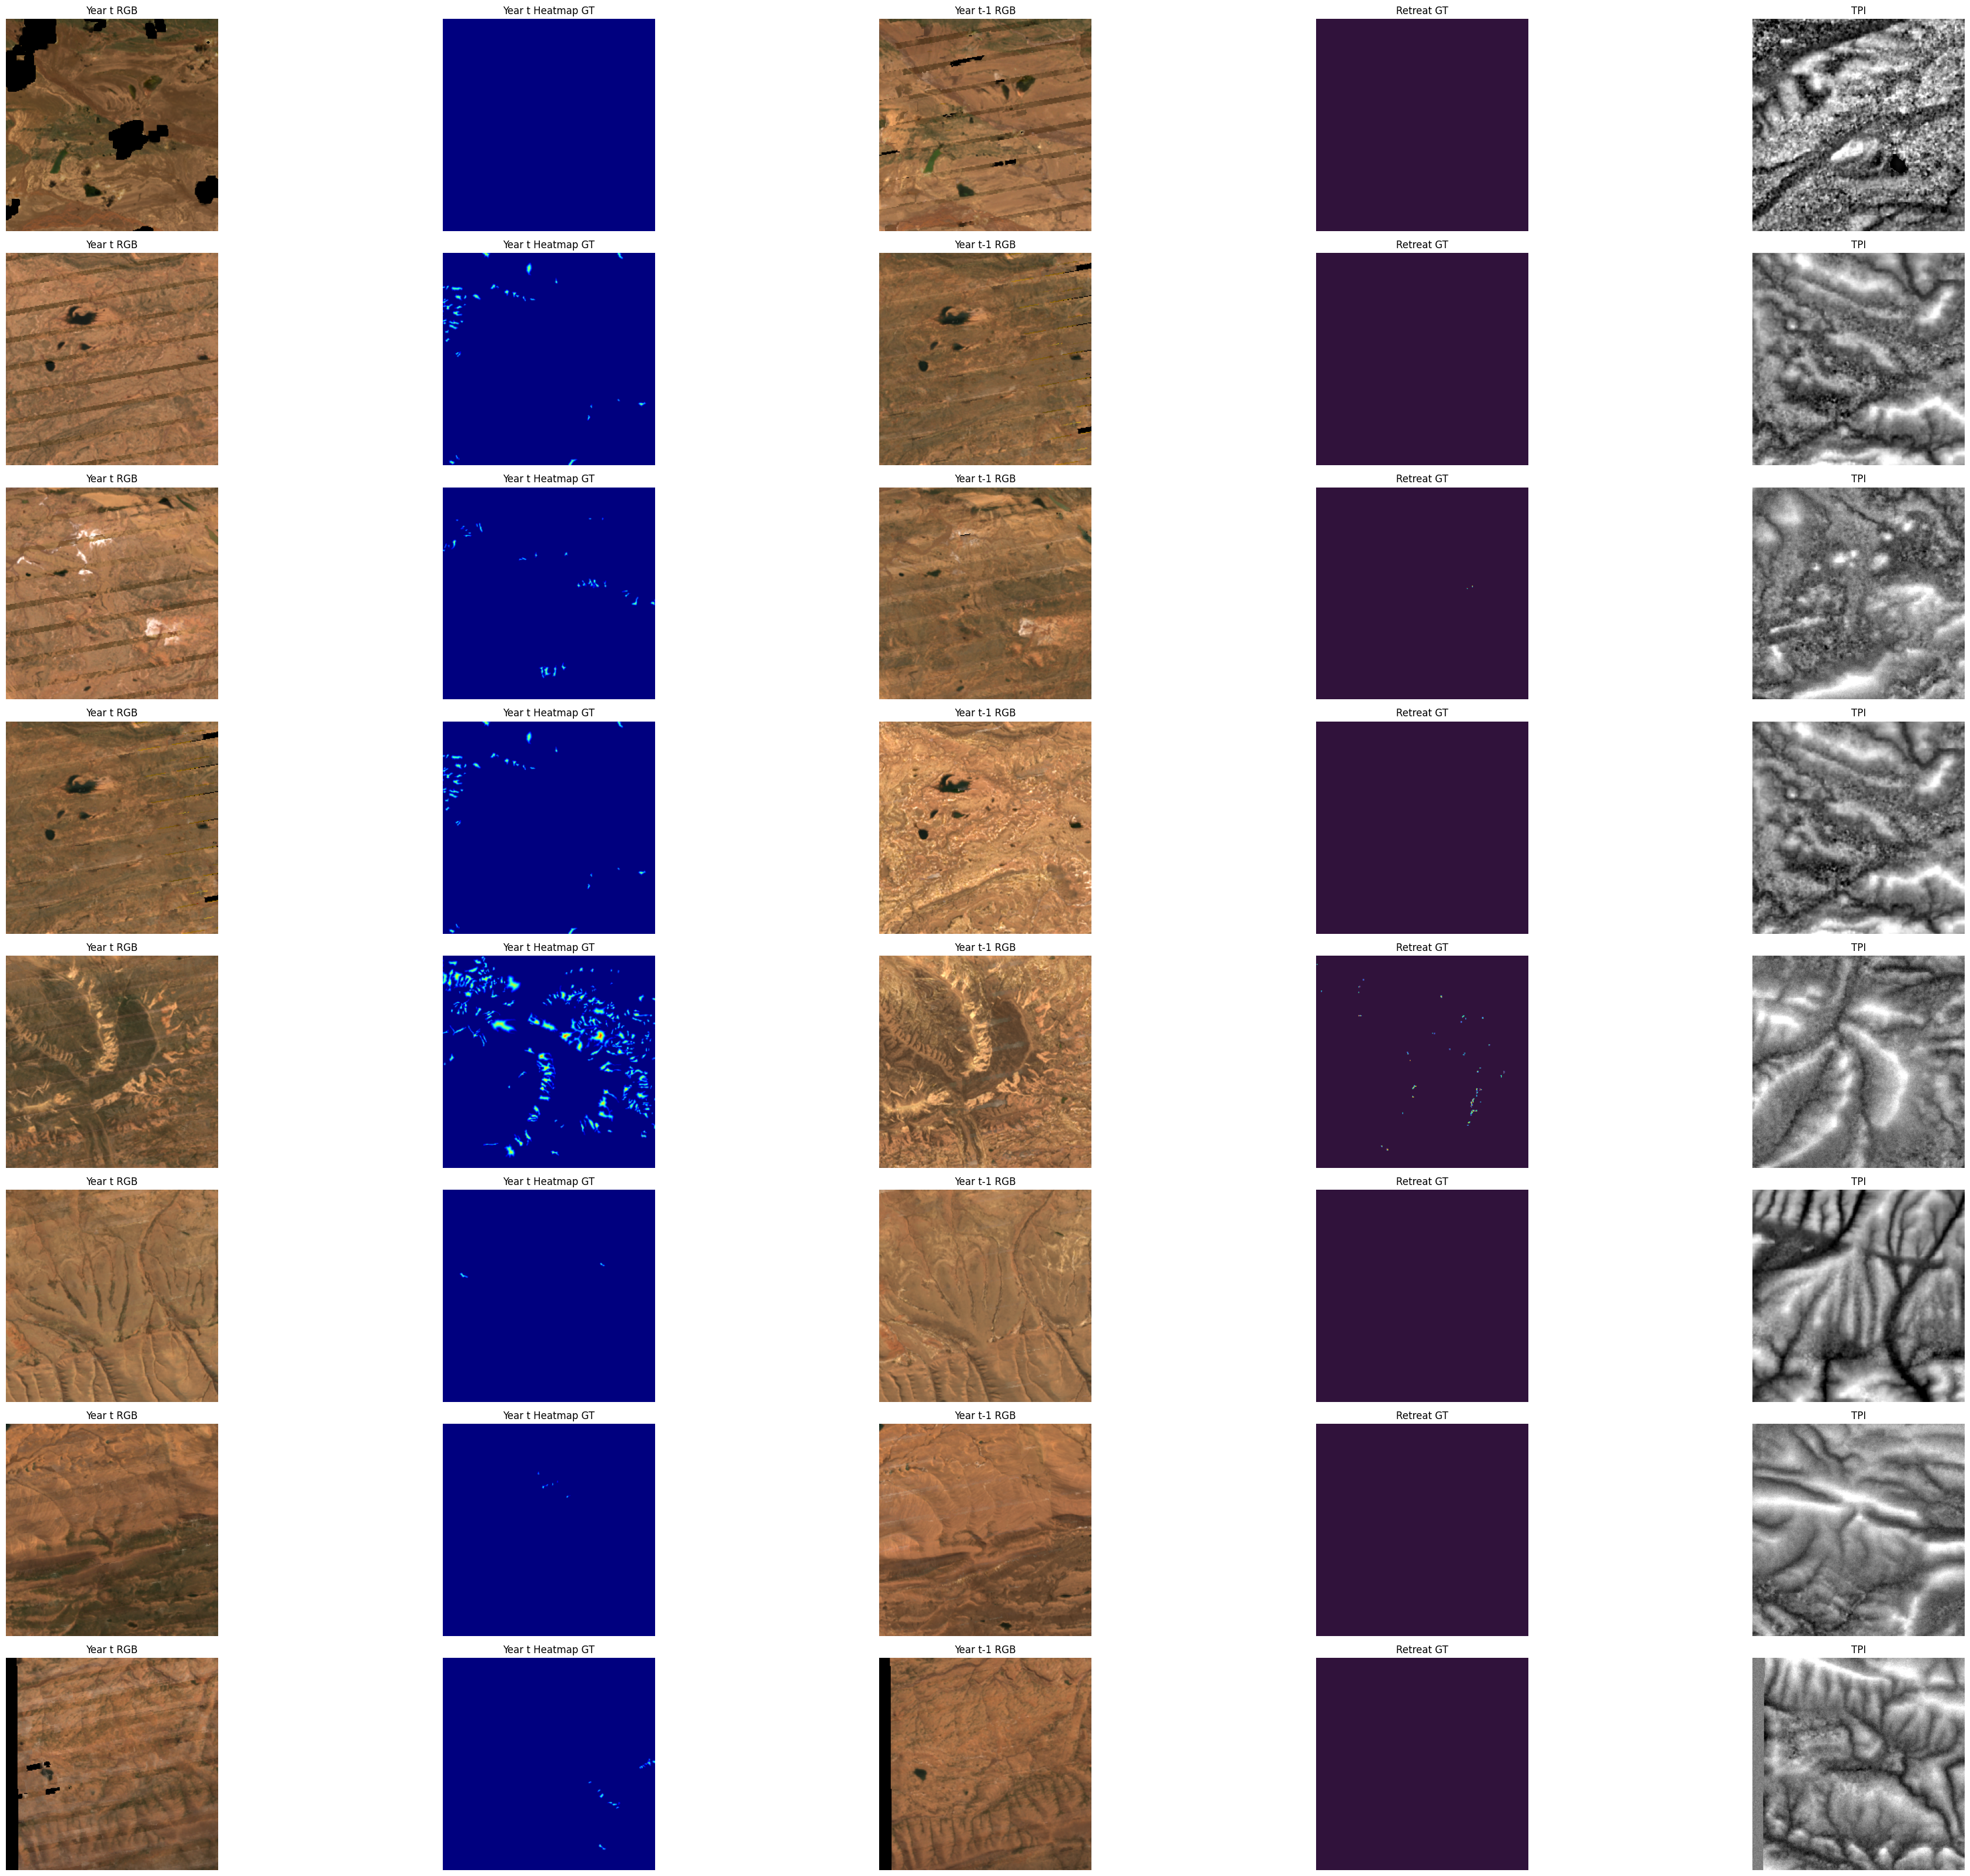

In [23]:
landsat_dm.show_batch(landsat_dm.train_dataloader, sample_num=8, bright=3, width=8)

## Initialize rts model

In [24]:
import torch.nn as nn

rts_model = SiameseRTS(
                    encoder_weights=ResNet50_Weights.SENTINEL2_ALL_MOCO,
                    in_bands=landsat_dm.bands,
                    use_dem=USE_DEM,
                    out_classes=2
)
rts_model.lr = nn.Parameter(torch.tensor(1e-4), requires_grad=False)
summary = ModelSummary(rts_model)
summary

ResNet50_Weights.SENTINEL2_ALL_MOCO  loaded
input shape of target weight torch.Size([64, 5, 7, 7])
input shape of loaded weight torch.Size([64, 13, 7, 7])


   | Name                   | Type                  | Params | Mode 
--------------------------------------------------------------------------
0  | shared_encoder         | TimmUniversalEncoder  | 23.5 M | train
1  | slump_decoder          | UnetPlusPlusDecoder   | 25.5 M | train
2  | retreat_decoder        | UnetPlusPlusDecoder   | 25.5 M | train
3  | dropout                | Dropout               | 0      | train
4  | fuser                  | FeatureFusionPerScale | 16.7 M | train
5  | seg_head               | ConvMLPHead           | 18.6 K | train
6  | heat_head              | ConvMLPHead           | 18.6 K | train
7  | retreat_head           | ConvMLPHead           | 9.3 K  | train
8  | loss_fn_dice           | DiceLoss              | 0      | train
9  | loss_fn_focal          | FocalLoss             | 0      | train
10 | loss_fn_mse            | MSELoss               | 0      | train
11 | loss_fn_area           | AreaPoolLoss          | 0      | train
12 | loss_fn_awing_weighted 

In [ ]:
# rts_model.model.decoder
# rts_model.model.segmentation_head

In [ ]:
# train_batch = next(iter(landsat_dm.val_dataloader()))
# dem = torch.unsqueeze(train_batch["mask"][:, 2, :, :], dim=1)
# print(dem.shape)
# print(train_batch['image'].shape)
# rts_model(train_batch['image'], dem=dem).shape

## Train rts model

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb_logger = WandbLogger(
    project="rts_retreat_project",
    name="unetpp_rgb_nir_dem_v1:1:0",
    save_dir="wandb_logs"
)


In [ ]:
# rts_model.lr = rts_model.lr * 10
# first stage
# rts_model.loss_weight_mse = rts_model.loss_weight_mse * 10
# second stage
# rts_model.loss_weight_mse = rts_model.loss_weight_mse * 10
# rts_model.lr = rts_model.lr * 0.1
# third stage
# rts_model.loss_weight_area = rts_model.loss_weight_area * 100

print("Loss weight dice:", rts_model.loss_weight_dice)
print("Loss weight focal:", rts_model.loss_weight_focal)
print("Loss weight mse:", rts_model.loss_weight_mse)
print("Loss weight area:", rts_model.loss_weight_area)

print("Task weight seg :",  rts_model.task_weight_seg.item())
print("Task weight heat:",  rts_model.task_weight_heat.item())
print("Task weight ret :",  rts_model.task_weight_ret.item())

print("Learning rate:", rts_model.lr)

# TODO: use scheduled learning strategy

logger = TensorBoardLogger(save_dir="lightning_logs",
                           name="rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test")

display(f'Current logging directory: {logger.log_dir}')
ckpt_callback = ModelCheckpoint(save_top_k=1,
                                save_last=False,
                                monitor="valid_loss",
                                verbose=True,
                                mode="min")
early_stop_callback = EarlyStopping(
   monitor='valid_loss',
   min_delta=0.001,
   patience=10,
   verbose=True,
   mode='min'
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=[0],
    max_epochs=50,
    log_every_n_steps=25,
   #  logger=logger,
      logger=wandb_logger,
   #  gradient_clip_val=0.5,      # 添加梯度裁剪
   #  gradient_clip_algorithm="norm",
    enable_progress_bar=True,
    callbacks=[RichProgressBar(leave=False), 
               ckpt_callback, 
               early_stop_callback]
)

Loss weight dice: Parameter containing:
tensor(1.)
Loss weight focal: Parameter containing:
tensor(1.)
Loss weight mse: Parameter containing:
tensor(1.)
Loss weight area: Parameter containing:
tensor(1.)
Task weight seg : 1.0
Task weight heat: 1.0
Task weight ret : 3.0
Learning rate: Parameter containing:
tensor(1.0000e-04)


'Current logging directory: lightning_logs/rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test/version_60'

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
# # 单批检查（验证集）
# dl = landsat_dm.val_dataloader()
# dl.num_workers = 0  # 先关多进程，避免阻塞
# b = next(iter(dl))

# def safe_minmax(t: torch.Tensor):
#     # 把 NaN 替换成 0，Inf 替换成有限值
#     t_clean = torch.nan_to_num(t, nan=0.0, posinf=1e10, neginf=-1e10)
#     return t_clean.min().item(), t_clean.max().item()

# def check_tensor(name, t):
#     if t is None: 
#         print(f"[batch] {name}=None")
#         return
#     finite = torch.isfinite(t).all().item()
#     n_nan = torch.isnan(t).sum().item()
#     n_inf = torch.isinf(t).sum().item()
#     min_val, max_val = safe_minmax(t)
#     print(
#         f"[batch] {name}: shape={tuple(t.shape)}, dtype={t.dtype}, device={t.device}, "
#         f"finite={finite}, NaN={n_nan}, Inf={n_inf}, min={min_val}, max={max_val}"
#     )

# for k in ["image_t","image_tm1","dem_t","dem_tm1","heatmap","mask","retreat_map"]:
#     check_tensor(k, b.get(k, None))


In [ ]:
print(torch.seed())
trainer.fit(rts_model, landsat_dm)

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.

13118976095341145342


wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/ww/.netrc.
wandb: Currently logged in as: wei-wu24 (wei-wu24-imperial-college-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                   ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ shared_encoder         │ TimmUniversalEncoder  │ 23.5 M │ train │
│ 1  │ slump_decoder          │ UnetPlusPlusDecoder   │ 25.5 M │ train │
│ 2  │ retreat_decoder        │ UnetPlusPlusDecoder   │ 25.5 M │ train │
│ 3  │ dropout                │ Dropout               │      0 │ train │
│ 4  │ fuser                  │ FeatureFusionPerScale │ 16.7 M │ train │
│ 5  │ seg_head               │ ConvMLPHead           │ 18.6 K │ train │
│ 6  │ heat_head              │ ConvMLPHead           │ 18.6 K │ train │
│ 7  │ retreat_head           │ ConvMLPHead           │ 18.6 K │ train │
│ 8  │ loss_fn_dice           │ DiceLoss              │      0 │ train │
│ 9  │ loss_fn_focal          │ FocalLoss             │      0 │ train │
│ 10 │ loss_fn_mse            │ MSELoss               │      0 │ train │
│ 11 │ loss_fn_area           │ AreaPoolLoss          │      0 │ train │
│ 12 │ loss_fn_awing_weighted │ LossWeightedAWing     │      0 │ train │
│ 13 │ loss_fn_ret            │ LossWeightedMSE       │      0 │ train │
│    │ other params           │ n/a                   │     10 │ n/a   │
└────┴────────────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 91.3 M                                                                                           
Non-trainable params: 10                                                                                           
Total params: 91.3 M                                                                                               
Total estimated model params size (MB): 365                                                                        
Modules in train mode: 555                                                                                         
Modules in eval mode: 0

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.
py:370: You have overridden `transfer_batch_to_device` in both `LightningModule` and `LightningDataModule`. It will
use the implementation from `LightningDataModule` instance.

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.996968150138855

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.38060590624809265

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.44980698823928833

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[valid epoch end] loss=38.1691, dice=0.9662, focal=0.0548, heat=18.3323, ret=5.2009, area=3.2130

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9519389271736145

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.726611316204071

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/torch/nn/functional.py:5167: UserWarning: Default 
grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify 
align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(

/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/torch/nn/functional.py:5100: UserWarning: Default 
grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify 
align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1335301399230957

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9768839478492737

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.657410204410553

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[valid epoch end] loss=1.1564, dice=0.9535, focal=0.0119, heat=0.1840, ret=0.0022, area=0.0005

[train epoch end] loss=1.3196, dice=0.9666, focal=0.0382, heat=0.2668, ret=0.0149, area=0.0032

Metric valid_loss improved. New best score: 1.157
Epoch 0, global step 100: 'valid_loss' reached 1.15670 (best 1.15670), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=0-step=100.ckpt' as top 1


[valid epoch end] loss=1.1032, dice=0.9086, focal=0.0120, heat=0.1762, ret=0.0020, area=0.0003

[train epoch end] loss=1.1648, dice=0.9457, focal=0.0128, heat=0.1908, ret=0.0049, area=0.0008

Metric valid_loss improved by 0.054 >= min_delta = 0.001. New best score: 1.103
Epoch 1, global step 200: 'valid_loss' reached 1.10301 (best 1.10301), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=1-step=200.ckpt' as top 1


[valid epoch end] loss=0.9810, dice=0.7459, focal=0.0273, heat=0.2014, ret=0.0019, area=0.0007

[train epoch end] loss=1.0767, dice=0.8679, focal=0.0191, heat=0.1762, ret=0.0042, area=0.0008

Metric valid_loss improved by 0.124 >= min_delta = 0.001. New best score: 0.979
Epoch 2, global step 300: 'valid_loss' reached 0.97934 (best 0.97934), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=2-step=300.ckpt' as top 1


[valid epoch end] loss=0.9859, dice=0.7326, focal=0.0449, heat=0.2025, ret=0.0019, area=0.0002

[train epoch end] loss=1.0148, dice=0.7945, focal=0.0336, heat=0.1756, ret=0.0035, area=0.0007

Epoch 3, global step 400: 'valid_loss' was not in top 1


[valid epoch end] loss=0.9354, dice=0.7092, focal=0.0457, heat=0.1749, ret=0.0017, area=0.0003

[train epoch end] loss=0.9787, dice=0.7757, focal=0.0376, heat=0.1562, ret=0.0029, area=0.0006

Metric valid_loss improved by 0.045 >= min_delta = 0.001. New best score: 0.934
Epoch 4, global step 500: 'valid_loss' reached 0.93418 (best 0.93418), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=4-step=500.ckpt' as top 1


[valid epoch end] loss=0.8858, dice=0.6679, focal=0.0437, heat=0.1696, ret=0.0015, area=0.0001

[train epoch end] loss=0.9488, dice=0.7488, focal=0.0404, heat=0.1516, ret=0.0025, area=0.0005

Metric valid_loss improved by 0.051 >= min_delta = 0.001. New best score: 0.883
Epoch 5, global step 600: 'valid_loss' reached 0.88334 (best 0.88334), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=5-step=600.ckpt' as top 1


[valid epoch end] loss=0.8880, dice=0.6542, focal=0.0444, heat=0.1852, ret=0.0014, area=0.0001

[train epoch end] loss=0.9145, dice=0.7086, focal=0.0414, heat=0.1567, ret=0.0024, area=0.0005

Epoch 6, global step 700: 'valid_loss' was not in top 1


[valid epoch end] loss=0.8643, dice=0.6599, focal=0.0402, heat=0.1605, ret=0.0012, area=0.0001

[train epoch end] loss=0.8944, dice=0.7000, focal=0.0406, heat=0.1465, ret=0.0023, area=0.0005

Metric valid_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.865
Epoch 7, global step 800: 'valid_loss' reached 0.86540 (best 0.86540), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=7-step=800.ckpt' as top 1


[valid epoch end] loss=0.8331, dice=0.6237, focal=0.0407, heat=0.1648, ret=0.0012, area=0.0001

[train epoch end] loss=0.8912, dice=0.6883, focal=0.0422, heat=0.1539, ret=0.0021, area=0.0005

Metric valid_loss improved by 0.030 >= min_delta = 0.001. New best score: 0.835
Epoch 8, global step 900: 'valid_loss' reached 0.83528 (best 0.83528), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=8-step=900.ckpt' as top 1


[valid epoch end] loss=0.8808, dice=0.6984, focal=0.0363, heat=0.1427, ret=0.0011, area=0.0001

[train epoch end] loss=0.8786, dice=0.6826, focal=0.0406, heat=0.1485, ret=0.0022, area=0.0004

Epoch 9, global step 1000: 'valid_loss' was not in top 1


[valid epoch end] loss=0.8378, dice=0.6285, focal=0.0428, heat=0.1637, ret=0.0009, area=0.0001

[train epoch end] loss=0.8719, dice=0.6664, focal=0.0440, heat=0.1546, ret=0.0021, area=0.0005

Epoch 10, global step 1100: 'valid_loss' was not in top 1


[valid epoch end] loss=0.7983, dice=0.5969, focal=0.0401, heat=0.1587, ret=0.0008, area=0.0001

[train epoch end] loss=0.8458, dice=0.6473, focal=0.0427, heat=0.1501, ret=0.0018, area=0.0004

Metric valid_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.801
Epoch 11, global step 1200: 'valid_loss' reached 0.80105 (best 0.80105), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=11-step=1200.ckpt' as top 1


[valid epoch end] loss=0.7958, dice=0.5960, focal=0.0405, heat=0.1568, ret=0.0008, area=0.0001

[train epoch end] loss=0.8137, dice=0.6146, focal=0.0435, heat=0.1502, ret=0.0017, area=0.0004

Metric valid_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.793
Epoch 12, global step 1300: 'valid_loss' reached 0.79342 (best 0.79342), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=12-step=1300.ckpt' as top 1


[valid epoch end] loss=0.8795, dice=0.6523, focal=0.0482, heat=0.1767, ret=0.0007, area=0.0001

[train epoch end] loss=0.7429, dice=0.5610, focal=0.0390, heat=0.1379, ret=0.0015, area=0.0003

Epoch 13, global step 1400: 'valid_loss' was not in top 1


[valid epoch end] loss=0.6810, dice=0.4689, focal=0.0406, heat=0.1692, ret=0.0008, area=0.0000

[train epoch end] loss=0.7407, dice=0.5582, focal=0.0396, heat=0.1381, ret=0.0015, area=0.0003

Metric valid_loss improved by 0.113 >= min_delta = 0.001. New best score: 0.681
Epoch 14, global step 1500: 'valid_loss' reached 0.68079 (best 0.68079), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=14-step=1500.ckpt' as top 1


[valid epoch end] loss=0.7642, dice=0.5634, focal=0.0430, heat=0.1558, ret=0.0006, area=0.0001

[train epoch end] loss=0.6829, dice=0.5112, focal=0.0368, heat=0.1304, ret=0.0014, area=0.0002

Epoch 15, global step 1600: 'valid_loss' was not in top 1


[valid epoch end] loss=0.6915, dice=0.5215, focal=0.0327, heat=0.1351, ret=0.0007, area=0.0001

[train epoch end] loss=0.6518, dice=0.4842, focal=0.0350, heat=0.1284, ret=0.0014, area=0.0002

Epoch 16, global step 1700: 'valid_loss' was not in top 1


[valid epoch end] loss=0.5982, dice=0.4156, focal=0.0338, heat=0.1465, ret=0.0008, area=0.0000

[train epoch end] loss=0.6168, dice=0.4502, focal=0.0341, heat=0.1279, ret=0.0015, area=0.0002

Metric valid_loss improved by 0.084 >= min_delta = 0.001. New best score: 0.597
Epoch 17, global step 1800: 'valid_loss' reached 0.59705 (best 0.59705), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=17-step=1800.ckpt' as top 1


[valid epoch end] loss=0.7083, dice=0.5394, focal=0.0353, heat=0.1317, ret=0.0006, area=0.0001

[train epoch end] loss=0.6096, dice=0.4424, focal=0.0340, heat=0.1289, ret=0.0013, area=0.0002

Epoch 18, global step 1900: 'valid_loss' was not in top 1


[valid epoch end] loss=0.6850, dice=0.4897, focal=0.0378, heat=0.1550, ret=0.0008, area=0.0001

[train epoch end] loss=0.6062, dice=0.4398, focal=0.0337, heat=0.1284, ret=0.0014, area=0.0002

Epoch 19, global step 2000: 'valid_loss' was not in top 1


[valid epoch end] loss=0.6508, dice=0.4856, focal=0.0344, heat=0.1290, ret=0.0006, area=0.0000

[train epoch end] loss=0.6227, dice=0.4668, focal=0.0336, heat=0.1185, ret=0.0012, area=0.0002

Epoch 20, global step 2100: 'valid_loss' was not in top 1


[valid epoch end] loss=0.6422, dice=0.4508, focal=0.0376, heat=0.1513, ret=0.0008, area=0.0000

[train epoch end] loss=0.5838, dice=0.4290, focal=0.0321, heat=0.1188, ret=0.0013, area=0.0001

Epoch 21, global step 2200: 'valid_loss' was not in top 1


[valid epoch end] loss=0.5912, dice=0.4172, focal=0.0359, heat=0.1362, ret=0.0006, area=0.0000

[train epoch end] loss=0.5551, dice=0.4029, focal=0.0318, heat=0.1168, ret=0.0012, area=0.0001

Metric valid_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.589
Epoch 22, global step 2300: 'valid_loss' reached 0.58890 (best 0.58890), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=22-step=2300.ckpt' as top 1


[valid epoch end] loss=0.6630, dice=0.4725, focal=0.0391, heat=0.1492, ret=0.0007, area=0.0001

[train epoch end] loss=0.5106, dice=0.3674, focal=0.0287, heat=0.1107, ret=0.0012, area=0.0001

Epoch 23, global step 2400: 'valid_loss' was not in top 1


[valid epoch end] loss=0.5290, dice=0.3516, focal=0.0310, heat=0.1441, ret=0.0008, area=0.0000

[train epoch end] loss=0.4852, dice=0.3430, focal=0.0282, heat=0.1106, ret=0.0011, area=0.0001

Metric valid_loss improved by 0.058 >= min_delta = 0.001. New best score: 0.531
Epoch 24, global step 2500: 'valid_loss' reached 0.53089 (best 0.53089), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=24-step=2500.ckpt' as top 1


[valid epoch end] loss=0.5053, dice=0.3462, focal=0.0293, heat=0.1275, ret=0.0007, area=0.0000

[train epoch end] loss=0.4609, dice=0.3258, focal=0.0263, heat=0.1052, ret=0.0011, area=0.0001

Metric valid_loss improved by 0.025 >= min_delta = 0.001. New best score: 0.506
Epoch 25, global step 2600: 'valid_loss' reached 0.50586 (best 0.50586), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=25-step=2600.ckpt' as top 1


[valid epoch end] loss=0.4824, dice=0.3290, focal=0.0273, heat=0.1240, ret=0.0007, area=0.0000

[train epoch end] loss=0.4563, dice=0.3232, focal=0.0259, heat=0.1037, ret=0.0011, area=0.0001

Metric valid_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.483
Epoch 26, global step 2700: 'valid_loss' reached 0.48263 (best 0.48263), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=26-step=2700.ckpt' as top 1


[valid epoch end] loss=0.5182, dice=0.3695, focal=0.0295, heat=0.1174, ret=0.0006, area=0.0000

[train epoch end] loss=0.4387, dice=0.3132, focal=0.0242, heat=0.0981, ret=0.0011, area=0.0001

Epoch 27, global step 2800: 'valid_loss' was not in top 1


[valid epoch end] loss=0.4785, dice=0.3122, focal=0.0287, heat=0.1353, ret=0.0007, area=0.0000

[train epoch end] loss=0.4334, dice=0.3117, focal=0.0236, heat=0.0948, ret=0.0011, area=0.0001

Metric valid_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.478
Epoch 28, global step 2900: 'valid_loss' reached 0.47833 (best 0.47833), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=28-step=2900.ckpt' as top 1


[valid epoch end] loss=0.5848, dice=0.4399, focal=0.0311, heat=0.1122, ret=0.0005, area=0.0000

[train epoch end] loss=0.4190, dice=0.2895, focal=0.0243, heat=0.1016, ret=0.0012, area=0.0001

Epoch 29, global step 3000: 'valid_loss' was not in top 1


[valid epoch end] loss=0.5031, dice=0.3549, focal=0.0292, heat=0.1172, ret=0.0006, area=0.0000

[train epoch end] loss=0.4397, dice=0.3113, focal=0.0251, heat=0.0999, ret=0.0011, area=0.0001

Epoch 30, global step 3100: 'valid_loss' was not in top 1


[valid epoch end] loss=0.4702, dice=0.3059, focal=0.0283, heat=0.1338, ret=0.0007, area=0.0000

[train epoch end] loss=0.4201, dice=0.2965, focal=0.0240, heat=0.0965, ret=0.0010, area=0.0001

Metric valid_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.470
Epoch 31, global step 3200: 'valid_loss' reached 0.47028 (best 0.47028), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=31-step=3200.ckpt' as top 1


[valid epoch end] loss=0.4962, dice=0.3552, focal=0.0259, heat=0.1133, ret=0.0006, area=0.0001

[train epoch end] loss=0.3865, dice=0.2710, focal=0.0223, heat=0.0899, ret=0.0011, area=0.0001

Epoch 32, global step 3300: 'valid_loss' was not in top 1


[valid epoch end] loss=0.4022, dice=0.2799, focal=0.0204, heat=0.1002, ret=0.0005, area=0.0000

[train epoch end] loss=0.3907, dice=0.2750, focal=0.0225, heat=0.0900, ret=0.0010, area=0.0000

Metric valid_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.404
Epoch 33, global step 3400: 'valid_loss' reached 0.40440 (best 0.40440), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=33-step=3400.ckpt' as top 1


[valid epoch end] loss=0.4254, dice=0.2859, focal=0.0250, heat=0.1128, ret=0.0006, area=0.0000

[train epoch end] loss=0.3612, dice=0.2531, focal=0.0205, heat=0.0846, ret=0.0010, area=0.0000

Epoch 34, global step 3500: 'valid_loss' was not in top 1


[valid epoch end] loss=0.3866, dice=0.2739, focal=0.0200, heat=0.0912, ret=0.0005, area=0.0000

[train epoch end] loss=0.3480, dice=0.2398, focal=0.0200, heat=0.0849, ret=0.0010, area=0.0000

Metric valid_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.387
Epoch 35, global step 3600: 'valid_loss' reached 0.38694 (best 0.38694), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=35-step=3600.ckpt' as top 1


[valid epoch end] loss=0.3810, dice=0.2347, focal=0.0235, heat=0.1207, ret=0.0007, area=0.0000

[train epoch end] loss=0.3270, dice=0.2293, focal=0.0180, heat=0.0767, ret=0.0010, area=0.0000

Metric valid_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.377
Epoch 36, global step 3700: 'valid_loss' reached 0.37729 (best 0.37729), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=36-step=3700.ckpt' as top 1


[valid epoch end] loss=0.3800, dice=0.2406, focal=0.0217, heat=0.1158, ret=0.0006, area=0.0000

[train epoch end] loss=0.3231, dice=0.2255, focal=0.0180, heat=0.0763, ret=0.0011, area=0.0000

Epoch 37, global step 3800: 'valid_loss' was not in top 1


[valid epoch end] loss=0.3742, dice=0.2498, focal=0.0202, heat=0.1024, ret=0.0006, area=0.0000

[train epoch end] loss=0.3118, dice=0.2138, focal=0.0175, heat=0.0773, ret=0.0011, area=0.0000

Metric valid_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.374
Epoch 38, global step 3900: 'valid_loss' reached 0.37414 (best 0.37414), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=38-step=3900.ckpt' as top 1


[valid epoch end] loss=0.3809, dice=0.2377, focal=0.0225, heat=0.1187, ret=0.0006, area=0.0000

[train epoch end] loss=0.3015, dice=0.2098, focal=0.0166, heat=0.0721, ret=0.0010, area=0.0000

Epoch 39, global step 4000: 'valid_loss' was not in top 1


[valid epoch end] loss=0.4016, dice=0.2657, focal=0.0234, heat=0.1106, ret=0.0006, area=0.0000

[train epoch end] loss=0.3255, dice=0.2250, focal=0.0183, heat=0.0790, ret=0.0011, area=0.0000

Epoch 40, global step 4100: 'valid_loss' was not in top 1


[valid epoch end] loss=0.3838, dice=0.2617, focal=0.0213, heat=0.0990, ret=0.0006, area=0.0000

[train epoch end] loss=0.3211, dice=0.2238, focal=0.0182, heat=0.0761, ret=0.0010, area=0.0000

Epoch 41, global step 4200: 'valid_loss' was not in top 1


[valid epoch end] loss=0.3829, dice=0.2414, focal=0.0252, heat=0.1144, ret=0.0006, area=0.0000

[train epoch end] loss=0.3096, dice=0.2146, focal=0.0176, heat=0.0743, ret=0.0010, area=0.0000

Epoch 42, global step 4300: 'valid_loss' was not in top 1


[valid epoch end] loss=0.3420, dice=0.2049, focal=0.0210, heat=0.1135, ret=0.0009, area=0.0000

[train epoch end] loss=0.2964, dice=0.2107, focal=0.0160, heat=0.0670, ret=0.0009, area=0.0000

Metric valid_loss improved by 0.030 >= min_delta = 0.001. New best score: 0.344
Epoch 43, global step 4400: 'valid_loss' reached 0.34404 (best 0.34404), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=43-step=4400.ckpt' as top 1


[valid epoch end] loss=0.3904, dice=0.2391, focal=0.0256, heat=0.1238, ret=0.0007, area=0.0000

[train epoch end] loss=0.2823, dice=0.1952, focal=0.0157, heat=0.0685, ret=0.0010, area=0.0000

Epoch 44, global step 4500: 'valid_loss' was not in top 1


[valid epoch end] loss=0.3276, dice=0.1884, focal=0.0197, heat=0.1173, ret=0.0007, area=0.0000

[train epoch end] loss=0.2650, dice=0.1818, focal=0.0147, heat=0.0655, ret=0.0010, area=0.0000

Metric valid_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.327
Epoch 45, global step 4600: 'valid_loss' reached 0.32657 (best 0.32657), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=45-step=4600.ckpt' as top 1


[valid epoch end] loss=0.3649, dice=0.2197, focal=0.0234, heat=0.1199, ret=0.0006, area=0.0000

[train epoch end] loss=0.2526, dice=0.1736, focal=0.0139, heat=0.0624, ret=0.0009, area=0.0000

Epoch 46, global step 4700: 'valid_loss' was not in top 1


[valid epoch end] loss=0.3196, dice=0.2011, focal=0.0179, heat=0.0988, ret=0.0006, area=0.0000

[train epoch end] loss=0.2404, dice=0.1627, focal=0.0133, heat=0.0617, ret=0.0009, area=0.0000

Metric valid_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.321
Epoch 47, global step 4800: 'valid_loss' reached 0.32141 (best 0.32141), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=47-step=4800.ckpt' as top 1


[valid epoch end] loss=0.3210, dice=0.2103, focal=0.0168, heat=0.0922, ret=0.0006, area=0.0000

[train epoch end] loss=0.2395, dice=0.1658, focal=0.0129, heat=0.0581, ret=0.0009, area=0.0000

Epoch 48, global step 4900: 'valid_loss' was not in top 1


[valid epoch end] loss=0.3082, dice=0.1946, focal=0.0171, heat=0.0949, ret=0.0005, area=0.0000

[train epoch end] loss=0.2361, dice=0.1630, focal=0.0128, heat=0.0577, ret=0.0009, area=0.0000

Metric valid_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.308
Epoch 49, global step 5000: 'valid_loss' reached 0.30773 (best 0.30773), saving model to 'wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=49-step=5000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
from pathlib import Path

logger_name = "rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test"

ckpt_path_best = Path("lightning_logs") / logger_name / "version_58" / "checkpoints" / "epoch=54-step=5500.ckpt"
# ckpt_path_best = Path("wandb_logs/rts_retreat_project/5bw83duh/checkpoints/epoch=49-step=5000.ckpt")
# ckpt_path_best = Path("wandb_logs/rts_retreat_project/jalt2ev1/checkpoints/epoch=53-step=5400.ckpt")
print("Best ckpt:", ckpt_path_best)

assert ckpt_path_best.exists(), "checkpoint 文件不存在，路径要再确认一下"

rts_model = SiameseRTS.load_from_checkpoint(checkpoint_path=ckpt_path_best,
                                          encoder_name="resnet50",
                                          encoder_weights=ResNet50_Weights.SENTINEL2_ALL_MOCO,
                                          in_bands=landsat_dm.bands,
                                          use_dem=USE_DEM,
                                          out_classes=2,
                                          )

Best ckpt: lightning_logs/rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test/version_58/checkpoints/epoch=54-step=5500.ckpt
ResNet50_Weights.SENTINEL2_ALL_MOCO  loaded
input shape of target weight torch.Size([64, 5, 7, 7])
input shape of loaded weight torch.Size([64, 13, 7, 7])


In [ ]:
# ckpt_dir = Path(logger.save_dir) / logger.name / f'version_{logger.version}' / 'checkpoints' # type: ignore
# ckpt_path_last = list(ckpt_dir.glob('epoch*.ckpt'))[0]
# ckpt_path_best = Path(logger.save_dir) / logger.name / "best_model.ckpt"


In [ ]:
# rts_model = SiameseRTS.load_from_checkpoint(checkpoint_path=ckpt_path_last,
#                                           encoder_name="resnet50",
#                                           encoder_weights=ResNet50_Weights.SENTINEL2_ALL_MOCO,
#                                           in_bands=landsat_dm.bands,
#                                           use_dem=USE_DEM,
#                                           out_classes=2
#                                           )


ResNet50_Weights.SENTINEL2_ALL_MOCO  loaded
input shape of target weight torch.Size([64, 5, 7, 7])
input shape of loaded weight torch.Size([64, 13, 7, 7])


## Test rts model

In [ ]:
# # 移除进度条回调（避免错误）
# trainer.callbacks = [
#     cb for cb in trainer.callbacks 
#     if not isinstance(cb, pl.callbacks.progress.rich_progress.RichProgressBar)
# ]

# run test dataset
torch.manual_seed(3407)
test_metrics = trainer.test(model=rts_model,
                            # ckpt_path="best", #"best"
                            ckpt_path=ckpt_path_best,
                            dataloaders=landsat_dm, verbose=False)
display(test_metrics)


Restoring states from the checkpoint path at lightning_logs/rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test/version_58/checkpoints/epoch=54-step=5500.ckpt


/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:445: The dirpath has changed from 'lightning_logs/rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test/version_58/checkpoints' to 'wandb_logs/rts_retreat_project/cj53zb48/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at lightning_logs/rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test/version_58/checkpoints/epoch=54-step=5500.ckpt


/home/ww/miniconda3/envs/torchgeo/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9146947860717773

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.5190080404281616

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.44980698823928833

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.44980698823928833

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.996968150138855

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9714794158935547

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9602434635162354

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.5190080404281616

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.996968150138855

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9593818187713623

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9714794158935547

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9593818187713623

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.44980698823928833

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.996968150138855

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.5190080404281616

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.44980698823928833

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.996968150138855

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.5536085963249207

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.996968150138855

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.1165721416473389

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9714794158935547

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.622809648513794

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9593818187713623

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.44980698823928833

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.9593818187713623

[check] mask finite=True, shape=(32, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(32, 1, 256, 256), min=0.0, max=0.44980698823928833

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[check] heatmap finite=True, shape=(8, 1, 256, 256), min=0.0, max=0.9146947860717773

[check] mask finite=True, shape=(8, 1, 256, 256), min=0.0, max=1.0

[check] retreat_map finite=True, shape=(8, 1, 256, 256), min=0.0, max=0.44980698823928833

loss finite: {'dice': True, 'focal': True, 'heat': True, 'ret': True, 'area': True}

[test epoch end] loss=0.1639, dice=0.1099, focal=0.0096, heat=0.0443, ret=0.2791, area=0.0000

[{'test_loss': 0.16459718346595764}]

In [ ]:
ckpt_path_best = Path(logger.save_dir) / logger.name / "best_model.ckpt"
print(ckpt_path_best)
trainer.save_checkpoint(ckpt_path_best, weights_only=True)


lightning_logs/rts_model_unetpp_s2_rgb_nir_dem_moco_blh_hxm_dem_aug_16_22_r4_4_awing_l7_year_roi_80s_test/best_model.ckpt


## Visualize demo results

In [ ]:
# # 获取预测结果
# predictions = trainer.predict(model=rts_model, datamodule=landsat_dm)

# # 正确的解包方式
# first_batch_pred = predictions[0]  # 第一个 batch 的预测结果

# # 从字典中提取需要的数据
# image_t = first_batch_pred["image_t"]
# image_tm1 = first_batch_pred["image_tm1"] 
# pred_retreat = first_batch_pred["pred_retreat"]
# pred_heat = first_batch_pred["pred_heat"]
# prob_mask = first_batch_pred["prob_mask"]

# print(f"Image t shape: {image_t.shape}")
# print(f"Image t-1 shape: {image_tm1.shape}")
# print(f"Predicted retreat shape: {pred_retreat.shape}")
# print(f"Predicted heatmap shape: {pred_heat.shape}")
# print(f"Predicted mask prob shape: {prob_mask.shape}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

rts_model.eval()
val_loader = landsat_dm.val_dataloader()
batch = next(iter(val_loader))

with torch.no_grad():
    outputs = rts_model(
        batch["image_t"].to(rts_model.device),
        batch["image_tm1"].to(rts_model.device),
        batch.get("dem_t", None).to(rts_model.device) if batch.get("dem_t", None) is not None else None,
        batch.get("dem_tm1", None).to(rts_model.device) if batch.get("dem_tm1", None) is not None else None,
    )
    logits_mask = outputs["logits_mask"]
    pred_heat = outputs["heatmap"]
    pred_ret = outputs["retreat"] * rts_model.retreat_scale   # 反缩放
    prob_mask = logits_mask.sigmoid()

# 全部搬回 CPU
image_t = batch["image_t"].cpu()       # [B,C,H,W]
image_tm1 = batch["image_tm1"].cpu()
gt_mask = batch["mask"].cpu()
gt_heat = batch["heatmap"].cpu()
gt_ret = batch.get("retreat_map", None)
if gt_ret is not None:
    gt_ret = gt_ret.cpu() * rts_model.retreat_scale  # 反缩放到真实单位

pred_mask = prob_mask.cpu()
pred_heat = pred_heat.cpu()
pred_ret = pred_ret.cpu()

In [ ]:
# ----------------- 工具函数 -----------------
def to_np(t: torch.Tensor):
    return t.detach().cpu().numpy()

# ----------------- 转 numpy 并 squeeze -----------------
imgs_t = image_t
imgs_tm1 = image_tm1

gt_masks = to_np(gt_mask)
gt_heats = to_np(gt_heat)
pr_masks = to_np(pred_mask)
pr_heats = to_np(pred_heat)
pr_rets = to_np(pred_ret)
gt_rets = to_np(gt_ret) if gt_ret is not None else None

if gt_masks.ndim == 4 and gt_masks.shape[1] == 1:
    gt_masks = gt_masks.squeeze(1)
if gt_heats.ndim == 4 and gt_heats.shape[1] == 1:
    gt_heats = gt_heats.squeeze(1)
if pr_masks.ndim == 4 and pr_masks.shape[1] == 1:
    pr_masks = pr_masks.squeeze(1)
if pr_heats.ndim == 4 and pr_heats.shape[1] == 1:
    pr_heats = pr_heats.squeeze(1)
if pr_rets.ndim == 4 and pr_rets.shape[1] == 1:
    pr_rets = pr_rets.squeeze(1)
if gt_rets is not None and gt_rets.ndim == 4 and gt_rets.shape[1] == 1:
    gt_rets = gt_rets.squeeze(1)

# ----------------- 画前 N 个样本 -----------------
N = min(32, imgs_t.shape[0])

seg_iou_list = []
heat_mse_list = []
heat_mae_list = []

for i in range(N):
    img_t = imgs_t[i]      # [C,H,W] (tensor)
    img_tm1 = imgs_tm1[i]
    m_gt = gt_masks[i]      # [H,W]
    m_pr = pr_masks[i]
    h_gt = gt_heats[i]
    h_pr = pr_heats[i]
    r_pr = pr_rets[i]
    r_gt = gt_rets[i] if gt_rets is not None else None

    # ---------- 计算误差 ----------
    # 1) segmentation：IoU / F1 / pixel 精度
    m_pr_bin = (m_pr > 0.5).astype(np.float32)
    inter = (m_pr_bin * m_gt).sum()
    union = (m_pr_bin + m_gt > 0).sum()
    iou   = inter / union if union > 0 else np.nan

    # 2) heatmap：MSE / MAE（只在有 GT 的地方）
    heat_mse = float(((h_pr - h_gt) ** 2).mean())
    heat_mae = float(np.abs(h_pr - h_gt).mean())

    # 3) retreat：MSE / MAE（只在有 GT 或有预测的地方）
    if r_gt is not None:
        valid = (np.isfinite(r_gt))  # 或 (r_gt > 0) | (r_pr > 0)
        if valid.sum() > 0:
            ret_mse = float(((r_pr[valid] - r_gt[valid]) ** 2).mean())
            ret_mae = float(np.abs(r_pr[valid] - r_gt[valid]).mean())
        else:
            ret_mse = np.nan
            ret_mae = np.nan
    else:
        ret_mse = np.nan
        ret_mae = np.nan

    seg_iou_list.append(iou)
    heat_mse_list.append(heat_mse)
    heat_mae_list.append(heat_mae)
    
    plt.figure(figsize=(30, 4))

    # 1) t 年 RGB
    plt.subplot(1, 9, 1)
    if img_t.shape[0] >= 3:
        rgb_image = img_t[:3, :, :].cpu().numpy()      # [3,H,W]
        rgb_image = np.transpose(rgb_image, (1, 2, 0)) # [H,W,3]
        rgb_image = np.clip((rgb_image + 2) / 4, 0, 1) # 简单线性拉伸
        plt.imshow(rgb_image)
    plt.title("Image t (RGB)")
    plt.axis("off")

    # 2) t-1 年 RGB
    plt.subplot(1, 9, 2)
    if img_tm1.shape[0] >= 3:
        rgb_tm1 = img_tm1[:3, :, :].cpu().numpy()
        rgb_tm1 = np.transpose(rgb_tm1, (1, 2, 0))
        rgb_tm1 = np.clip((rgb_tm1 + 2) / 4, 0, 1)
        plt.imshow(rgb_tm1)
    plt.title("Image t-1 (RGB)")
    plt.axis("off")

    # 3) t 年 TPI（dem_t）
    plt.subplot(1, 9, 3)
    if img_t.shape[0] > 3:
        plt.imshow(img_t[3].numpy(), cmap="gray")
        plt.title("Mean TPI t")
    plt.axis("off")

    # 4) Segment GT
    plt.subplot(1, 9, 4)
    plt.imshow(m_gt, cmap="gray", vmin=0, vmax=1)
    plt.title("Segment GT")
    plt.axis("off")

    # 5) Segment Pred
    plt.subplot(1, 9, 5)
    plt.imshow(m_pr, cmap="gray", vmin=0, vmax=1)
    plt.title("Segment Pred")
    plt.axis("off")

    # 6) Heatmap GT（0–1 归一化的）
    plt.subplot(1, 9, 6)
    plt.imshow(h_gt, vmin=0, vmax=1.3, cmap="jet")
    plt.title("Heatmap GT")
    plt.axis("off")

    # 7) Heatmap Pred
    plt.subplot(1, 9, 7)
    plt.imshow(np.clip(h_pr, 0, 1.5), vmin=0, vmax=1.3, cmap="jet")
    plt.title("Heatmap Pred")
    plt.axis("off")

    # 8) Retreat GT
    plt.subplot(1, 9, 8)
    if r_gt is not None:
        vmax_gt = max(float(r_gt.max()), 1.0)
        plt.imshow(np.clip(r_gt, 0, vmax_gt), cmap="plasma", vmin=0, vmax=vmax_gt)
    else:
        plt.imshow(np.zeros_like(r_pr), cmap="plasma", vmin=0, vmax=1)
    plt.title("Retreat GT")
    plt.axis("off")

    # 9) Retreat Pred
    plt.subplot(1, 9, 9)
    vmax_pr = max(float(r_pr.max()), 1.0)
    plt.imshow(np.clip(r_pr, 0, vmax_pr), cmap="plasma", vmin=0, vmax=vmax_pr)
    plt.title("Retreat Pred")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # 统计信息
    print(f"Sample {i+1} stats:")
    print(f"GT mask nonzero pixels: {m_gt.sum():.0f}")
    print(f"Pred mask nonzero>0.5: {(m_pr>0.5).sum():.0f}")
    print(f"Seg IoU: {iou:.3f}")
    print(f"GT heat max: {h_gt.max():.3f}")
    print(f"Pred heat max: {h_pr.max():.3f}")
    print(f"Heat MSE / MAE: {heat_mse:.6f} / {heat_mae:.6f}")
    print(f"Pred retreat max: {r_pr.max():.3f}")
    if r_gt is not None:
        print(f"GT retreat max: {r_gt.max():.3f}")
        print(f"Retreat MSE / MAE: {ret_mse:.6f} / {ret_mae:.6f}")
    print("-"*60)

In [ ]:
seg_iou_arr = np.array(seg_iou_list, dtype=np.float32)
heat_mse_arr = np.array(heat_mse_list, dtype=np.float32)
heat_mae_arr = np.array(heat_mae_list, dtype=np.float32)

def summary(arr, name):
    arr_valid = arr[~np.isnan(arr)]
    print(f"{name}:")
    print(f"count = {len(arr_valid)}")
    print(f"mean = {arr_valid.mean():.6f}")
    print(f"median = {np.median(arr_valid):.6f}")
    print(f"p25/p75 = {np.percentile(arr_valid,25):.6f} / {np.percentile(arr_valid,75):.6f}")
    print(f"min/max = {arr_valid.min():.6f} / {arr_valid.max():.6f}")
    print("-"*60)

summary(seg_iou_arr, "Seg IoU")
summary(heat_mse_arr, "Heat MSE")
summary(heat_mae_arr, "Heat MAE")

Seg IoU:
count = 27
mean = 0.578850
median = 0.683126
p25/p75 = 0.339551 / 0.815374
min/max = 0.000000 / 0.954577
------------------------------------------------------------
Heat MSE:
count = 32
mean = 0.000279
median = 0.000101
p25/p75 = 0.000043 / 0.000320
min/max = 0.000024 / 0.001512
------------------------------------------------------------
Heat MAE:
count = 32
mean = 0.005879
median = 0.004618
p25/p75 = 0.004232 / 0.006043
min/max = 0.003668 / 0.018108
------------------------------------------------------------


bias

In [ ]:
# 1. 简单 Bias：平均预测值 - 平均真实值
bias_simple = (h_pr - h_gt).mean()
print(f"Simple Bias (mean pred - mean gt): {bias_simple:.6f}")

# 2. 按像素计算 Bias
bias_per_pixel = h_pr - h_gt  # [H,W]
bias_mean = bias_per_pixel.mean()
bias_std = bias_per_pixel.std()
print(f"Bias Mean: {bias_mean:.6f}, Bias Std: {bias_std:.6f}")

# 3. 在 GT 非零区域计算 Bias（更有意义）
mask_gt_valid = (h_gt > 0.01)  # 或其他阈值
if mask_gt_valid.sum() > 0:
    bias_in_valid = (h_pr[mask_gt_valid] - h_gt[mask_gt_valid]).mean()
    print(f"Bias in GT valid region: {bias_in_valid:.6f}")

# 4. 对多个样本汇总统计 Bias
bias_list = []
for i in range(N):
    h_gt = gt_heats[i]
    h_pr = pr_heats[i]
    mask_valid = (h_gt > 0.01)
    if mask_valid.sum() > 0:
        bias = (h_pr[mask_valid] - h_gt[mask_valid]).mean()
        bias_list.append(bias)

bias_arr = np.array(bias_list, dtype=np.float32)
print(f"\nBias Statistics Across Samples:")
print(f"Mean: {bias_arr.mean():.6f}")
print(f"Std: {bias_arr.std():.6f}")
print(f"Min/Max: {bias_arr.min():.6f} / {bias_arr.max():.6f}")

Simple Bias (mean pred - mean gt): 0.000814
Bias Mean: 0.000814, Bias Std: 0.004930

Bias Statistics Across Samples:
Mean: -0.043985
Std: 0.037262
Min/Max: -0.130644 / 0.004371


In [ ]:
# 在 Bias 统计可视化单元格后添加

# ===================== 统计可视化 =====================
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. IoU 分布直方图
ax = axes[0, 0]
ax.hist(seg_iou_arr[~np.isnan(seg_iou_arr)], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(np.nanmean(seg_iou_arr), color='red', linestyle='--', label=f'Mean={np.nanmean(seg_iou_arr):.3f}')
ax.axvline(np.nanmedian(seg_iou_arr), color='orange', linestyle='--', label=f'Median={np.nanmedian(seg_iou_arr):.3f}')
ax.set_xlabel('IoU')
ax.set_ylabel('Count')
ax.set_title('Segmentation IoU Distribution')
ax.legend()

# 2. Heatmap MAE 分布
ax = axes[0, 1]
ax.hist(heat_mae_arr, bins=20, edgecolor='black', alpha=0.7, color='coral')
ax.axvline(heat_mae_arr.mean(), color='red', linestyle='--', label=f'Mean={heat_mae_arr.mean():.4f}')
ax.set_xlabel('MAE')
ax.set_ylabel('Count')
ax.set_title('Heatmap MAE Distribution')
ax.legend()

# 3. Heatmap Bias 分布
ax = axes[0, 2]
ax.hist(bias_arr, bins=20, edgecolor='black', alpha=0.7, color='mediumpurple')
ax.axvline(0, color='black', linestyle='-', linewidth=2)
ax.axvline(bias_arr.mean(), color='red', linestyle='--', label=f'Mean={bias_arr.mean():.4f}')
ax.set_xlabel('Bias (Pred - GT)')
ax.set_ylabel('Count')
ax.set_title('Heatmap Bias Distribution')
ax.legend()

# 4. GT vs Pred 散点图 (Heatmap 均值)
ax = axes[1, 0]
gt_means = [gt_heats[i].mean() for i in range(N)]
pr_means = [pr_heats[i].mean() for i in range(N)]
ax.scatter(gt_means, pr_means, alpha=0.6, edgecolor='k', s=50)
lims = [0, max(max(gt_means), max(pr_means)) * 1.1]
ax.plot(lims, lims, 'r--', label='y=x (Perfect)')
ax.set_xlabel('GT Heatmap Mean')
ax.set_ylabel('Pred Heatmap Mean')
ax.set_title('GT vs Pred Heatmap (Mean per Sample)')
ax.legend()
ax.set_xlim(lims)
ax.set_ylim(lims)

# 5. Boxplot 比较
ax = axes[1, 1]
data_box = [seg_iou_arr[~np.isnan(seg_iou_arr)], heat_mae_arr, np.abs(bias_arr)]
bp = ax.boxplot(data_box, labels=['IoU', 'MAE', '|Bias|'], patch_artist=True)
colors = ['steelblue', 'coral', 'mediumpurple']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Value')
ax.set_title('Metrics Boxplot Comparison')

# 6. 误差统计汇总表
ax = axes[1, 2]
ax.axis('off')
stats_text = f"""
╔══════════════════════════════════════════╗
║         EVALUATION SUMMARY               ║
╠══════════════════════════════════════════╣
║ Segmentation IoU                         ║
║   Mean: {np.nanmean(seg_iou_arr):.4f}  Median: {np.nanmedian(seg_iou_arr):.4f}     ║
║   Min: {np.nanmin(seg_iou_arr):.4f}   Max: {np.nanmax(seg_iou_arr):.4f}        ║
╠══════════════════════════════════════════╣
║ Heatmap MAE                              ║
║   Mean: {heat_mae_arr.mean():.4f}  Std: {heat_mae_arr.std():.4f}       ║
╠══════════════════════════════════════════╣
║ Heatmap MSE                              ║
║   Mean: {heat_mse_arr.mean():.6f}  Std: {heat_mse_arr.std():.6f} ║
╠══════════════════════════════════════════╣
║ Heatmap Bias                             ║
║   Mean: {bias_arr.mean():+.4f}  Std: {bias_arr.std():.4f}      ║
║   (+ = over-predict, - = under-predict)  ║
╚══════════════════════════════════════════╝
"""
ax.text(0.1, 0.5, stats_text, fontsize=10, family='monospace', 
        verticalalignment='center', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [ ]:
bias_list = []
bias_valid_list = []

for i in range(N):
    h_gt = gt_heats[i]
    h_pr = pr_heats[i]
    
    bias_full = (h_pr - h_gt).mean()
    bias_list.append(bias_full)
    
    mask_valid = (h_gt > 0.01)
    if mask_valid.sum() > 0:
        bias_valid = (h_pr[mask_valid] - h_gt[mask_valid]).mean()
        bias_valid_list.append(bias_valid)

bias_arr = np.array(bias_list, dtype=np.float32)
bias_valid_arr = np.array(bias_valid_list, dtype=np.float32)

print("=" * 60)
print("Heatmap Bias Statistics:")
print(f"Full Image Bias - Mean: {bias_arr.mean():.6f}, Std: {bias_arr.std():.6f}")
print(f"Valid Region Bias - Mean: {bias_valid_arr.mean():.6f}, Std: {bias_valid_arr.std():.6f}")
print("=" * 60)

for i in range(min(32, N)):
    h_gt = gt_heats[i]
    h_pr = pr_heats[i]
    bias_map = h_pr - h_gt
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # GT Heatmap
    im0 = axes[0].imshow(h_gt, vmin=0, vmax=1.3, cmap="jet")
    axes[0].set_title(f"Sample {i}: GT Heatmap")
    axes[0].axis("off")
    plt.colorbar(im0, ax=axes[0], fraction=0.046)
    
    # Pred Heatmap
    im1 = axes[1].imshow(np.clip(h_pr, 0, 1.5), vmin=0, vmax=1.3, cmap="jet")
    axes[1].set_title(f"Pred Heatmap")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046)
    
    # Bias Map
    im2 = axes[2].imshow(bias_map, cmap='jet', vmin=-0.5, vmax=0.5)
    axes[2].set_title(f"Bias (Pred-GT), mean={bias_map.mean():.3f}")
    axes[2].axis("off")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, label='Over/Under')
    
    plt.tight_layout()
    plt.show()